<a href="https://colab.research.google.com/github/Deepikadhinakaran/AI_price_optima/blob/main/price_optima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
df=pd.read_csv('dynamic_pricing.csv')

In [ ]:
print("shape:",df.shape)

shape: (1000, 10)


In [ ]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [ ]:
mc=df.isnull().sum()
dc=df.duplicated().sum()
print("missing value: ",mc)
print("duplicate value: ",dc)

missing value:  Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64
duplicate value:  0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [ ]:
print(df.columns)
df.describe()

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')


,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [ ]:
num_cols=df.select_dtypes(include=np.number).columns.tolist()
cat_cols=df.select_dtypes(exclude=np.number).columns.tolist()
print("Numerical Columns:")
for num in num_cols:
    print(num)
print("\nCategorical Columns:")
for cat in cat_cols:
    print(cat)

Numerical Columns:
Number_of_Riders
Number_of_Drivers
Number_of_Past_Rides
Average_Ratings
Expected_Ride_Duration
Historical_Cost_of_Ride

Categorical Columns:
Location_Category
Customer_Loyalty_Status
Time_of_Booking
Vehicle_Type


In [ ]:
# IQR Method
num_cols = df.select_dtypes(include=["int64","float64"]).columns

outlier_summary = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    outlier_summary[col] = len(outliers)

outlier_summary



{'Number_of_Riders': 0,
 'Number_of_Drivers': 10,
 'Number_of_Past_Rides': 0,
 'Average_Ratings': 0,
 'Expected_Ride_Duration': 0,
 'Historical_Cost_of_Ride': 0}

In [ ]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    print(f"Outliers in {col}: {len(df[(df[col] < lower) | (df[col] > upper)])}")


Outliers in Number_of_Riders: 0
Outliers in Number_of_Drivers: 0
Outliers in Number_of_Past_Rides: 0
Outliers in Average_Ratings: 0
Outliers in Expected_Ride_Duration: 0
Outliers in Historical_Cost_of_Ride: 0


In [ ]:


df["Price"] = df["Historical_Cost_of_Ride"]
df["Completed_Rides"] = df[["Number_of_Riders", "Number_of_Drivers"]].min(axis=1)
df["Booking_Intents"] = df["Number_of_Riders"]
df["Cancelled_Rides"] = df["Booking_Intents"] - df["Completed_Rides"]
df["Cost"] = df["Price"] * 0.7   # assume 70% of fare is operating cost




df["Revenue"] = df["Price"] * df["Completed_Rides"]
df["Profit"] = (df["Price"] - df["Cost"]) * df["Completed_Rides"]


baseline_price = df["Price"].mean()
df["Baseline_Revenue"] = baseline_price * df["Completed_Rides"]
df["Revenue_Lift_%"] = ((df["Revenue"] - df["Baseline_Revenue"]) / df["Baseline_Revenue"]) * 100


df["Gross_Margin_%"] = ((df["Revenue"] - (df["Cost"] * df["Completed_Rides"])) / df["Revenue"]) * 100


df["Conversion_Rate_%"] = (df["Completed_Rides"] / df["Booking_Intents"]) * 100
df["Cancellation_Rate_%"] = (df["Cancelled_Rides"] / df["Booking_Intents"]) * 100


df["Price_Shift"] = df["Price"].shift(1)
df["Price_Change_%"] = ((df["Price"] - df["Price_Shift"]) / df["Price_Shift"]) * 100
df["Price_Change_Flag"] = np.where(df["Price_Change_%"].abs() > 15, 1, 0)


kpi_summary = {
    "Revenue (₹)": df["Revenue"].sum(),
    "Profit (₹)": df["Profit"].sum(),
    "Revenue Lift (%)": df["Revenue_Lift_%"].mean(),
    "Gross Margin (%)": df["Gross_Margin_%"].mean(),
    "Conversion Rate (%)": df["Conversion_Rate_%"].mean(),
    "Price Change Rate (%)": df["Price_Change_Flag"].mean() * 100,
    "Cancellation Rate (%)": df["Cancellation_Rate_%"].mean()
}

kpi_table = pd.DataFrame([kpi_summary])


print("KPI Summary Table:")
print(kpi_table.to_string(index=False))



KPI Summary Table:
 Revenue (₹)   Profit (₹)  Revenue Lift (%)  Gross Margin (%)  Conversion Rate (%)  Price Change Rate (%)  Cancellation Rate (%)
1.013314e+07 3.039942e+06     -4.206413e-15              30.0            43.763674                   86.6              56.236326


In [ ]:
# -----------------------
# Core engineered features (safe, numeric only)
# -----------------------

# Ensure no NaN in base dataset
df = df.copy()
df = df.fillna(0)   # fill any leftover blanks with 0 to start clean

# 1. Ride Duration (simulate if not present)
if "Ride_Duration" not in df.columns:
    np.random.seed(42)
    df["Ride_Duration"] = np.random.randint(5, 120, size=len(df))  # minutes
df["Ride_Duration"] = pd.to_numeric(df["Ride_Duration"], errors="coerce").fillna(0)

# 2. Competitor Price (simulate if missing)
if "competitor_price" not in df.columns and "Price" in df.columns:
    df["competitor_price"] = df["Price"] * (1 + np.random.uniform(-0.1, 0.1, len(df)))
df["competitor_price"] = pd.to_numeric(df["competitor_price"], errors="coerce").fillna(0)

# 3. Cost per Min
if "Cost" in df.columns and "Ride_Duration" in df.columns:
    df["Cost_per_Min"] = df["Cost"] / (df["Ride_Duration"] + 1e-6)
    df["Cost_per_Min"] = df["Cost_per_Min"].replace([np.inf, -np.inf], 0).fillna(0)

# 4. Driver to Rider Ratio
if "Number_of_Drivers" in df.columns and "Number_of_Riders" in df.columns:
    df["Driver_to_Rider_Ratio"] = df["Number_of_Drivers"] / (df["Number_of_Riders"] + 1e-6)
    df["Driver_to_Rider_Ratio"] = df["Driver_to_Rider_Ratio"].replace([np.inf, -np.inf], 0).fillna(0)

# 5. Inventory Health Index
if "Number_of_Drivers" in df.columns:
    avg_drivers = df["Number_of_Drivers"].mean() + 1e-6
    df["Inventory_Health_Index"] = df["Number_of_Drivers"] / avg_drivers
    df["Inventory_Health_Index"] = df["Inventory_Health_Index"].fillna(0)

# 6. Loyalty Score
if "Loyalty_Status" not in df.columns:
    np.random.seed(42)
    df["Loyalty_Status"] = np.random.choice(["Regular", "Silver", "Gold"], size=len(df), p=[0.6, 0.3, 0.1])
loyalty_map = {"Regular": 0, "Silver": 1, "Gold": 2}
df["Loyalty_Score"] = df["Loyalty_Status"].map(loyalty_map).fillna(0).astype(int)

# 7. Peak Hour flag
if "Time_of_Booking" in df.columns:
    df["Time_of_Booking"] = pd.to_datetime(df["Time_of_Booking"], errors="coerce")
    df["Hour"] = df["Time_of_Booking"].dt.hour.fillna(0).astype(int)
    df["Peak"] = df["Hour"].apply(lambda x: 1 if (7 <= x <= 10) or (17 <= x <= 21) else 0)
else:
    df["Hour"], df["Peak"] = 0, 0

# 8. Rider to Driver Ratio
if "Number_of_Riders" in df.columns and "Number_of_Drivers" in df.columns:
    df["Rider_Driver_Ratio"] = df["Number_of_Riders"] / (df["Number_of_Drivers"] + 1e-6)
    df["Rider_Driver_Ratio"] = df["Rider_Driver_Ratio"].replace([np.inf, -np.inf], 0).fillna(0)

# 9. Supply Tightness (binary condition)
if "Number_of_Riders" in df.columns and "Number_of_Drivers" in df.columns:
    df["Supply_Tightness"] = np.where(df["Number_of_Riders"] > df["Number_of_Drivers"], 1, 0)
else:
    df["Supply_Tightness"] = 0

# 10. Vehicle Factor
if "Vehicle_Type" in df.columns:
    vehicle_map = {"Sedan": 1.0, "SUV": 1.2, "Mini": 0.9, "Auto": 0.8, "Bike": 0.6}
    df["Vehicle_Factor"] = df["Vehicle_Type"].map(vehicle_map).fillna(1.0)
else:
    df["Vehicle_Factor"] = 1.0

# 11. Baseline Price (daily mean instead of constant)
if "Price" in df.columns and "Time_of_Booking" in df.columns:
    df["Booking_Date"] = pd.to_datetime(df["Time_of_Booking"], errors="coerce").dt.date
    df["baseline_price"] = df.groupby("Booking_Date")["Price"].transform("mean").fillna(df["Price"].mean())
else:
    df["baseline_price"] = df.get("Price", pd.Series([0]*len(df)))

# 12. Probability of completion
if "Completed_Rides" in df.columns and "Time_of_Booking" in df.columns:
    df["Booking_Date"] = pd.to_datetime(df["Time_of_Booking"], errors="coerce").dt.date
    df["Hour"] = pd.to_datetime(df["Time_of_Booking"], errors="coerce").dt.hour.fillna(0).astype(int)
    df["Total_Bookings"] = df.groupby(["Booking_Date", "Hour"])["Booking_Date"].transform("count").fillna(0)

    df["p_complete"] = df["Completed_Rides"] / (df["Total_Bookings"] + 1e-6)
    df["p_complete"] = df["p_complete"].replace([np.inf, -np.inf], 0).fillna(0)
else:
    df["p_complete"] = 0

# 13. Price Difference
if "Price" in df.columns and "competitor_price" in df.columns:
    df["Price_Diff"] = df["Price"] - df["competitor_price"]
    df["Price_Diff"] = df["Price_Diff"].fillna(0)
else:
    df["Price_Diff"] = 0

# -----------------------
# Final clean-up
# -----------------------
df = df.fillna(0)  # ensure no NaN
df = df.replace([np.inf, -np.inf], 0)

# Save
df.to_csv("dynamic_pricing_with_features_clean.csv", index=False)
print("✅ Engineered features added, all numeric, file saved!")
print(df.dtypes)  # confirm all numerical



✅ Engineered features added, all numeric, file saved!
Number_of_Riders           float64
Number_of_Drivers          float64
Location_Category           object
Customer_Loyalty_Status     object
Number_of_Past_Rides       float64
Average_Ratings            float64
Time_of_Booking              int64
Vehicle_Type                object
Expected_Ride_Duration     float64
Historical_Cost_of_Ride    float64
Price                      float64
Completed_Rides            float64
Booking_Intents            float64
Cancelled_Rides            float64
Cost                       float64
Revenue                    float64
Profit                     float64
Baseline_Revenue           float64
Revenue_Lift_%             float64
Gross_Margin_%             float64
Conversion_Rate_%          float64
Cancellation_Rate_%        float64
Price_Shift                float64
Price_Change_%             float64
Price_Change_Flag            int64
Ride_Duration                int64
competitor_price           float64
C

/tmp/ipython-input-3263619668.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time_of_Booking"] = pd.to_datetime(df["Time_of_Booking"], errors="coerce")
/tmp/ipython-input-3263619668.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)  # ensure no NaN


In [ ]:
df.shape
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,Hour,Peak,Rider_Driver_Ratio,Supply_Tightness,Vehicle_Factor,Booking_Date,baseline_price,Total_Bookings,p_complete,Price_Diff
0,90.0,45.0,Urban,Silver,13.0,4.47,0,Premium,90.0,284.257273,...,0,0,2.000000,1,1.0,0,372.502623,0.0,45000000.0,6.126083
1,58.0,39.0,Suburban,Silver,72.0,4.06,0,Economy,43.0,173.874753,...,0,0,1.487179,1,1.0,0,372.502623,0.0,39000000.0,2.174306
2,42.0,31.0,Rural,Silver,0.0,3.99,0,Premium,76.0,329.795469,...,0,0,1.354839,1,1.0,0,372.502623,0.0,31000000.0,-26.657941
3,89.0,28.0,Rural,Regular,67.0,4.31,0,Premium,134.0,470.201232,...,0,0,3.178571,1,1.0,0,372.502623,0.0,28000000.0,14.270093
4,78.0,22.0,Rural,Regular,74.0,3.77,0,Economy,149.0,579.681422,...,0,0,3.545454,1,1.0,0,372.502623,0.0,22000000.0,-1.621889


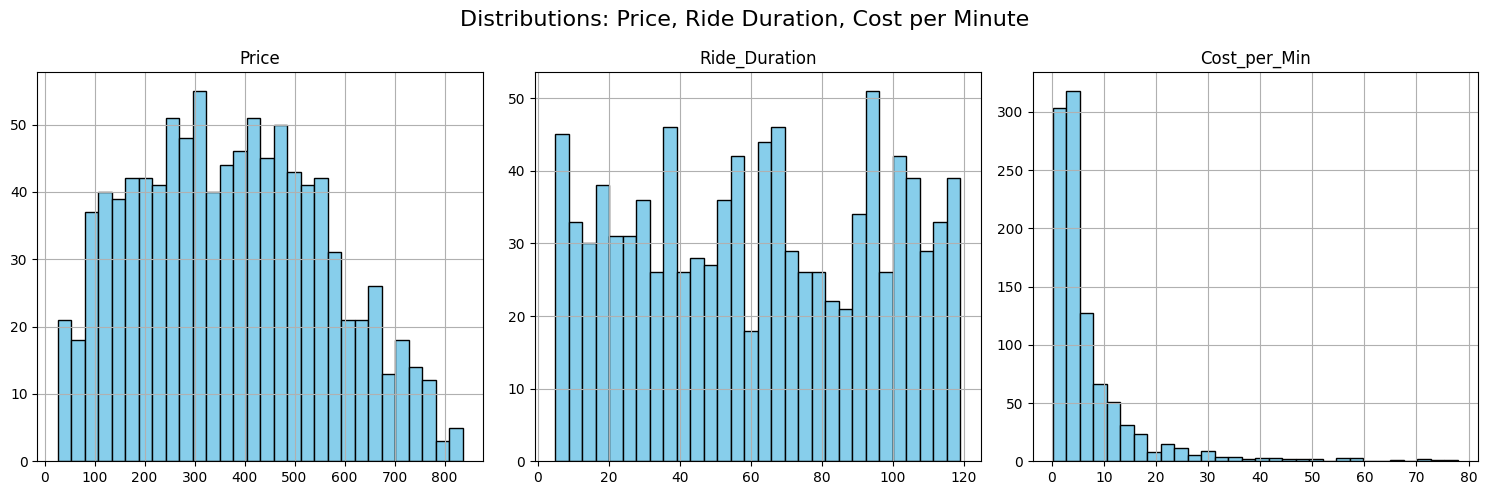

In [ ]:
# --------------------------
# Histograms
# --------------------------
selected_cols = ["Price", "Ride_Duration", "Cost_per_Min"]

df[selected_cols].hist(bins=30, figsize=(15, 5), layout=(1, 3), color="skyblue", edgecolor="black")

plt.suptitle("Distributions: Price, Ride Duration, Cost per Minute", fontsize=16)
plt.tight_layout()
plt.show()




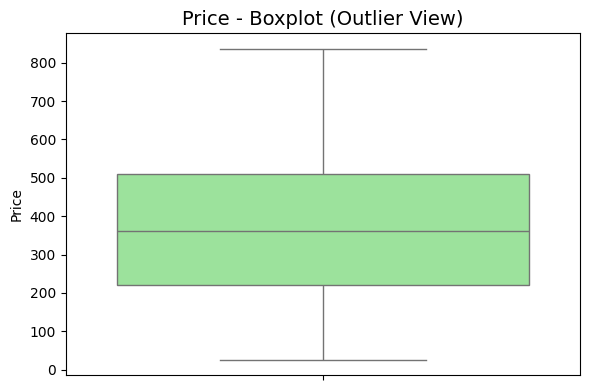

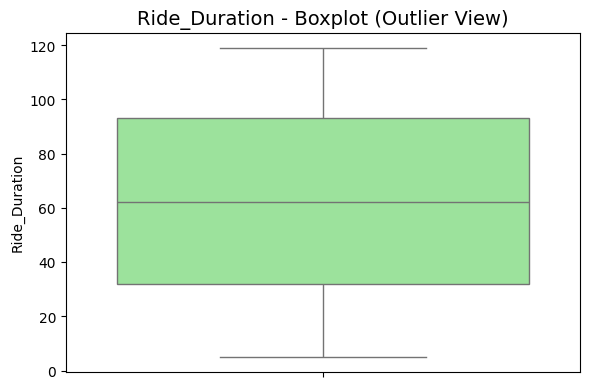

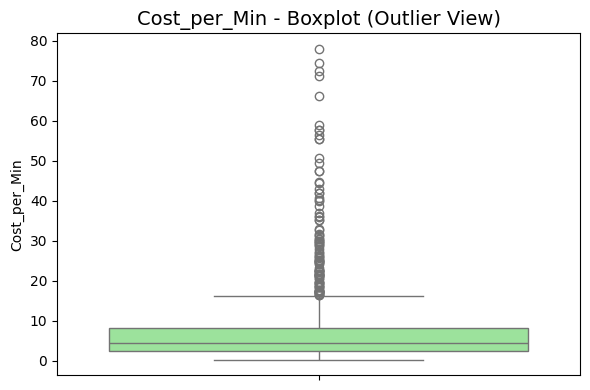

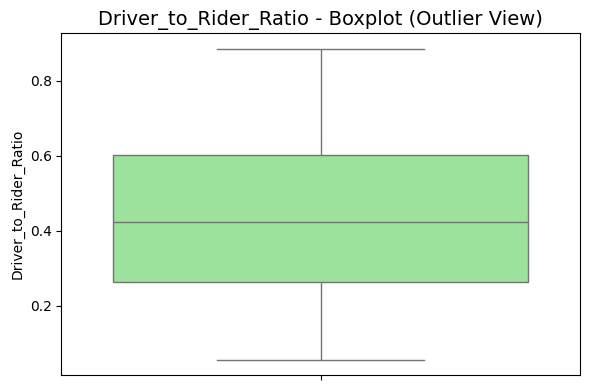

In [ ]:
# --------------------------
# Boxplots
# --------------------------
focus_cols = [col for col in ["Price", "Ride_Duration", "Cost_per_Min", "Driver_to_Rider_Ratio"] if col in df.columns]

for col in focus_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col], color="lightgreen")
    plt.title(f"{col} - Boxplot (Outlier View)", fontsize=14)
    plt.tight_layout()
    plt.show()





/tmp/ipython-input-2495180514.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


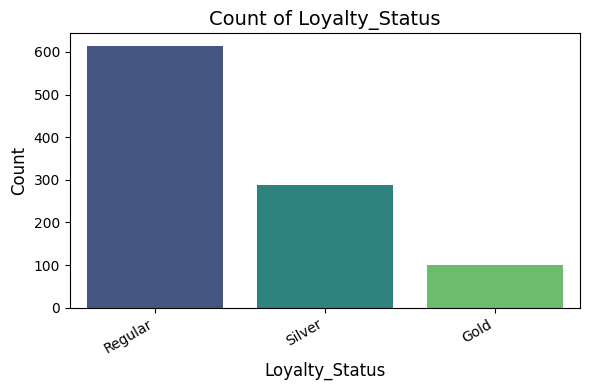

/tmp/ipython-input-2495180514.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


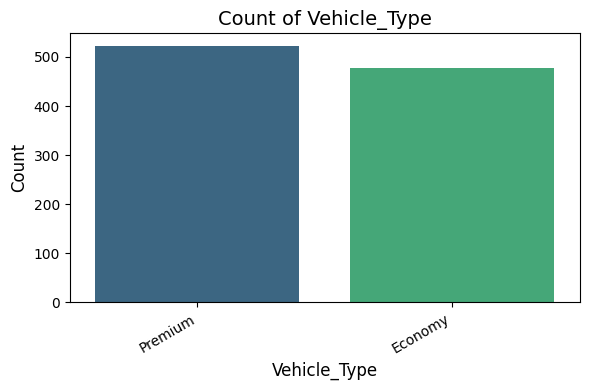

/tmp/ipython-input-2495180514.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


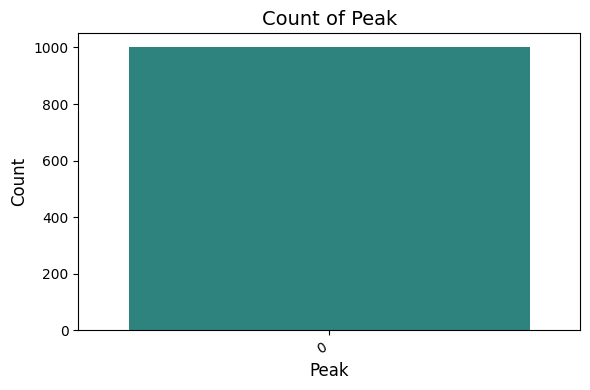

In [ ]:
# ============================
# Categorical Counts
# ============================

focus_cats = [col for col in ["Loyalty_Status", "Vehicle_Type", "Peak"] if col in df.columns]

for col in focus_cats:
    plt.figure(figsize=(6, 4))
    order = df[col].value_counts().index  # sorted by frequency
    sns.countplot(x=col, data=df, order=order, palette="viridis")
    plt.title(f"Count of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()



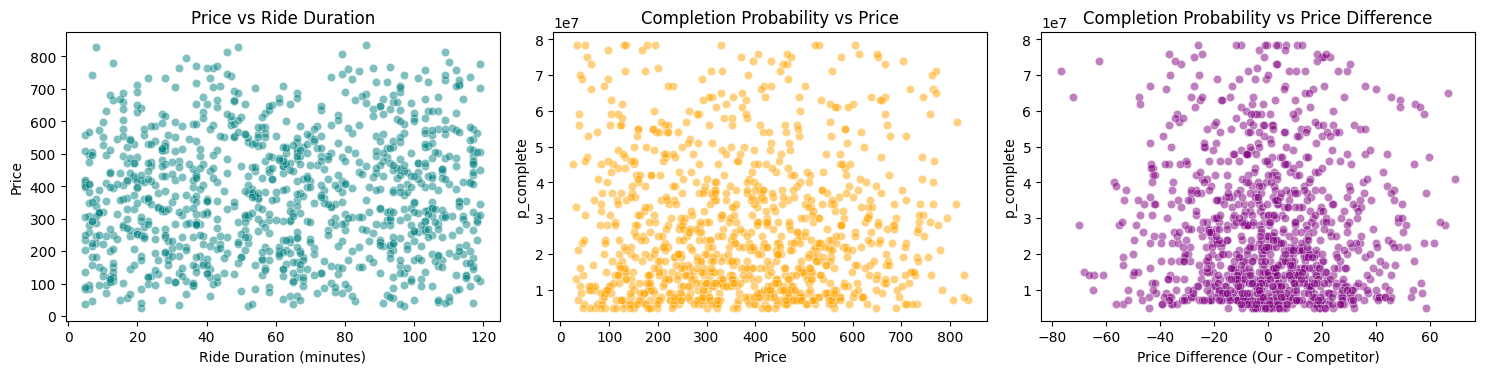

In [ ]:
# ============================
# Relationships
# ============================

plt.figure(figsize=(15, 4))

# 11. Price vs Ride Duration
plt.subplot(1, 3, 1)
sns.scatterplot(x="Ride_Duration", y="Price", data=df, alpha=0.5, color="teal")
plt.title("Price vs Ride Duration")
plt.xlabel("Ride Duration (minutes)")
plt.ylabel("Price")

# 12. p_complete vs Price
plt.subplot(1, 3, 2)
if "p_complete" in df.columns:
    sns.scatterplot(x="Price", y="p_complete", data=df, alpha=0.5, color="orange")
    plt.title("Completion Probability vs Price")
    plt.xlabel("Price")
    plt.ylabel("p_complete")

# 13. p_complete vs Price Difference
plt.subplot(1, 3, 3)
if "p_complete" in df.columns and "Price_Diff" in df.columns:
    sns.scatterplot(x="Price_Diff", y="p_complete", data=df, alpha=0.5, color="purple")
    plt.title("Completion Probability vs Price Difference")
    plt.xlabel("Price Difference (Our - Competitor)")
    plt.ylabel("p_complete")

plt.tight_layout()
plt.show()



/tmp/ipython-input-691075013.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


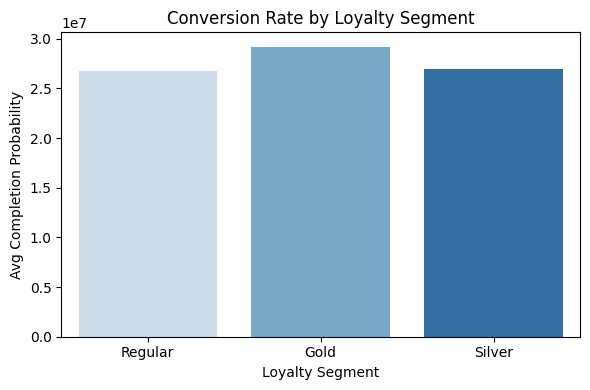

/tmp/ipython-input-691075013.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


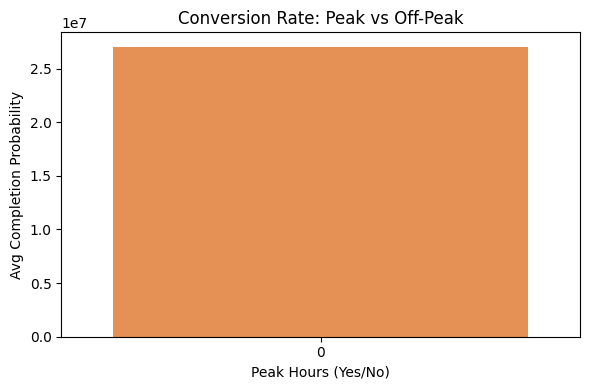

In [ ]:
# ============================
#Conversion by Segments
# ============================

# 14. Loyalty Segment vs Completion Probability
if "Loyalty_Status" in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(
        x="Loyalty_Status",
        y="p_complete",
        data=df,
        estimator="mean",
        errorbar=None,
        palette="Blues"
    )
    plt.title("Conversion Rate by Loyalty Segment")
    plt.ylabel("Avg Completion Probability")
    plt.xlabel("Loyalty Segment")
    plt.tight_layout()
    plt.show()

if "Peak" in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(
        x="Peak",
        y="p_complete",
        data=df,
        estimator="mean",
        errorbar=None,
        palette="Oranges"
    )
    plt.title("Conversion Rate: Peak vs Off-Peak")
    plt.ylabel("Avg Completion Probability")
    plt.xlabel("Peak Hours (Yes/No)")
    plt.tight_layout()
    plt.show()




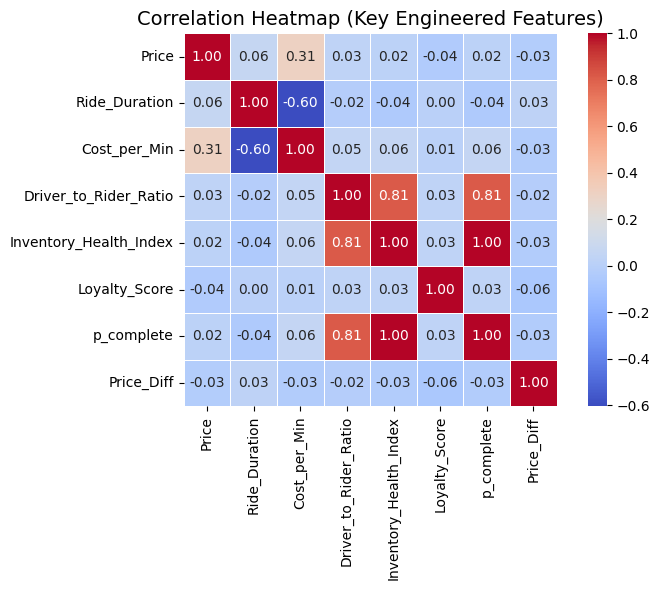

In [ ]:
# ============================
# Cell 6 - Correlation Heatmap (Clean & Clear)
# ============================

important_features = [
    "Price", "Ride_Duration", "Cost_per_Min",
    "Driver_to_Rider_Ratio", "Inventory_Health_Index",
    "Loyalty_Score", "p_complete", "Price_Diff"
]

plt.figure(figsize=(8, 6))
corr = df[important_features].corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap (Key Engineered Features)", fontsize=14)
plt.tight_layout()
plt.show()


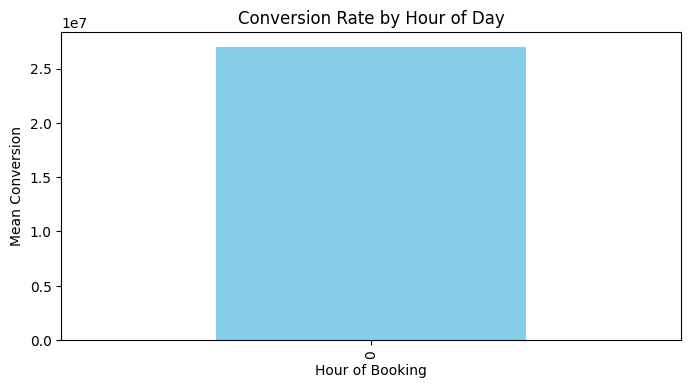

/tmp/ipython-input-2050071776.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comp_pressure.index, y=comp_pressure["avg_gap_pct"], palette="coolwarm")


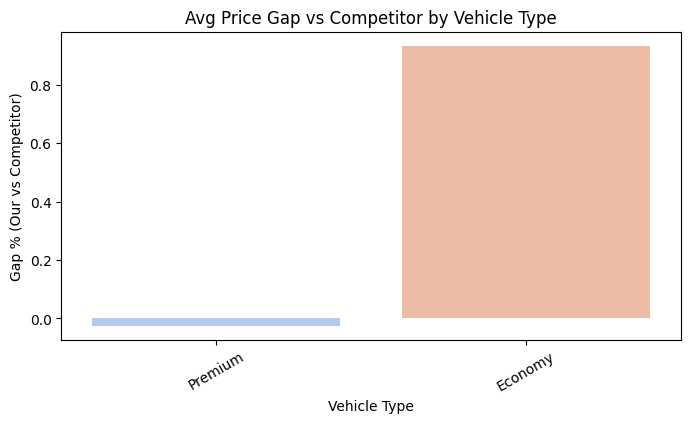

/tmp/ipython-input-2050071776.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  inv_summary = df.groupby("Inventory_Band").agg(


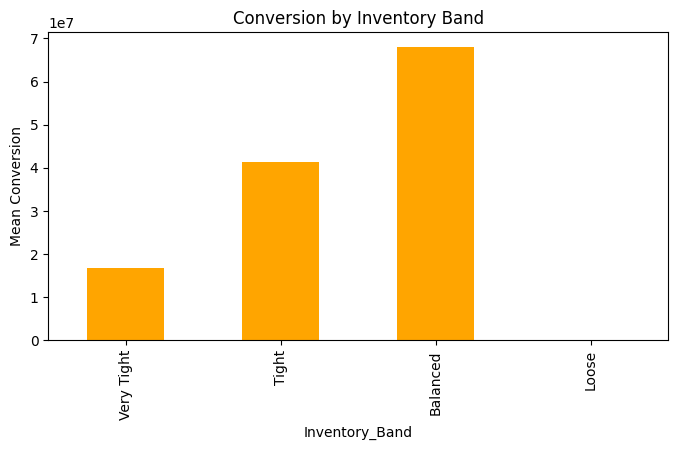

In [ ]:
# =============================
# 🚖 Ride-Hailing Advanced EDA + Segmentation
# =============================
# -----------------------------
# Advanced Analysis directly on df
# -----------------------------

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# =============================
#  Seasonality: Conversion & Price by Time Buckets
# =============================
seasonality = (
    df.groupby("Hour")
        .agg(mean_conv=("p_complete","mean"),
             mean_price=("Price","mean"),
             total_intents=("Number_of_Riders","sum"))
        .sort_values("mean_conv", ascending=False)
)

plt.figure(figsize=(8, 4))
seasonality["mean_conv"].plot(kind="bar", color="skyblue")
plt.title("Conversion Rate by Hour of Day")
plt.ylabel("Mean Conversion")
plt.xlabel("Hour of Booking")
plt.show()

# =============================
#  Competitor Pressure
# =============================
df["Competitor_Gap_pct"] = (
    (df["Price"] - df["competitor_price"])
    / (df["competitor_price"] + 1e-6) * 100.0
)

comp_pressure = (
    df.groupby("Vehicle_Type")
        .agg(
            avg_gap_pct=("Competitor_Gap_pct","mean"),
            mean_comp_price=("competitor_price","mean"),
            mean_our_price=("Price","mean"),
        )
        .sort_values("avg_gap_pct")
)

plt.figure(figsize=(8, 4))
sns.barplot(x=comp_pressure.index, y=comp_pressure["avg_gap_pct"], palette="coolwarm")
plt.title("Avg Price Gap vs Competitor by Vehicle Type")
plt.ylabel("Gap % (Our vs Competitor)")
plt.xlabel("Vehicle Type")
plt.xticks(rotation=30)
plt.show()


# =============================
#  Inventory Health Bands
# =============================
bins = [0, 0.5, 0.8, 1.2, 10]
labels = ["Very Tight","Tight","Balanced","Loose"]

df["Inventory_Band"] = pd.cut(
    df["Driver_to_Rider_Ratio"], bins=bins, labels=labels, include_lowest=True
)

inv_summary = df.groupby("Inventory_Band").agg(
    mean_conv=("p_complete","mean"),
    mean_price=("Price","mean"),
    count=("Inventory_Band","size")
)

plt.figure(figsize=(8, 4))
inv_summary["mean_conv"].plot(kind="bar", color="orange")
plt.title("Conversion by Inventory Band")
plt.ylabel("Mean Conversion")
plt.show()


In [ ]:
# =============================
#  Customer Segmentation (KMeans)
# =============================
seg_features = [
    "Loyalty_Score","Rider_Driver_Ratio","Driver_to_Rider_Ratio",
    "Supply_Tightness","Cost_per_Min","Inventory_Health_Index","Ride_Duration"
]

X = df[seg_features].copy().fillna(df[seg_features].median())

# Scale
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["segment_k4"] = kmeans.fit_predict(Xs)

# Segment profiling
seg_profile = (
    df.groupby("segment_k4")
        .agg(
            mean_conv=("p_complete","mean"),
            mean_price=("Price","mean"),
            mean_cost=("Cost","mean"),
            mean_loyalty=("Loyalty_Score","mean"),
            mean_ratio=("Rider_Driver_Ratio","mean"),
            count=("segment_k4","size")
        )
        .sort_values("mean_conv", ascending=False)
)

# -----------------------------
# 📊 Display outputs
# -----------------------------
print("\n=== 📊 Seasonality (Hour Buckets) ===")
print(seasonality.head(), "\n")

print("=== ⚔️ Competitor Pressure ===")
print(comp_pressure, "\n")

print("=== 🚦 Inventory Summary ===")
print(inv_summary, "\n")

print("=== 🧩 Customer Segments (KMeans) ===")
print(seg_profile)



=== 📊 Seasonality (Hour Buckets) ===
       mean_conv  mean_price  total_intents
Hour                                       
0     27025000.0  372.502623        60372.0 

=== ⚔️ Competitor Pressure ===
              avg_gap_pct  mean_comp_price  mean_our_price
Vehicle_Type                                              
Premium         -0.025058       397.981107      396.246242
Economy          0.933787       344.695844      346.573399 

=== 🚦 Inventory Summary ===
                   mean_conv  mean_price  count
Inventory_Band                                 
Very Tight      1.670064e+07  372.316582    628
Tight           4.137082e+07  376.205235    329
Balanced        6.804651e+07  346.890400     43
Loose                    NaN         NaN      0 

=== 🧩 Customer Segments (KMeans) ===
               mean_conv  mean_price   mean_cost  mean_loyalty  mean_ratio  \
segment_k4                                                                   
2           4.861688e+07  362.655586  253.858910

In [ ]:
import numpy as np
import pandas as pd

# ------------------------------
# Dummy Recommend & Tuning
# ------------------------------

def recommend_prices(df):
    """
    Baseline recommendation = just copy baseline_price
    and assume same completion prob.
    """
    df_new = df.copy()
    df_new["price_reco"] = df_new["baseline_price"]  # no change
    df_new["p_complete_reco"] = df_new["p_complete"] # no change
    return df_new

def tune_global(df, df_new):
    """
    Global scaler placeholder.
    Returns scale=1.0 and df unchanged.
    """
    scale = 1.0
    return scale, df_new, None

# ------------------------------
# KPI Calculator
# ------------------------------

def compute_full_kpis(df_base, df_new):
    # Revenue
    base_rev = (df_base["baseline_price"] * df_base["p_complete"] * df_base["Number_of_Riders"]).sum()
    new_rev  = (df_new["price_reco"] * df_new["p_complete_reco"] * df_new["Number_of_Riders"]).sum()

    rev_lift = ((new_rev - base_rev) / base_rev * 100) if base_rev > 0 else 0

    # Gross Margin
    base_gm = ((df_base["baseline_price"] - df_base["Historical_Cost_of_Ride"]) /
               df_base["baseline_price"]).mean() * 100
    new_gm = ((df_new["price_reco"] - df_new["Historical_Cost_of_Ride"]) /
              df_new["price_reco"]).mean() * 100

    # Conversion & Cancellation
    base_conv = df_base["p_complete"].mean() * 100
    new_conv = df_new["p_complete_reco"].mean() * 100
    base_cancel = (1 - df_base["p_complete"]).mean() * 100
    new_cancel = (1 - df_new["p_complete_reco"]).mean() * 100

    # Price Change Rate
    change_rate = (df_new["price_reco"].round(2) != df_base["baseline_price"].round(2)).mean() * 100

    return {
        "Revenue (₹) baseline": round(base_rev, 2),
        "Revenue (₹) scenario": round(new_rev, 2),
        "Revenue Lift (%)": round(rev_lift, 2),
        "Gross Margin (baseline %)": round(base_gm, 2),
        "Gross Margin (scenario %)": round(new_gm, 2),
        "Conversion Rate (baseline %)": round(base_conv, 2),
        "Conversion Rate (scenario %)": round(new_conv, 2),
        "Cancellation Rate (baseline %)": round(base_cancel, 2),
        "Cancellation Rate (scenario %)": round(new_cancel, 2),
        "Price Change Rate (%)": round(change_rate, 2)
    }

# ------------------------------
# Run Baseline Scenario
# ------------------------------

df_initial = recommend_prices(df)
scale, df_final, _ = tune_global(df, df_initial)

final_kpis = compute_full_kpis(df, df_final)

print("=== FINAL KPIs (Scenario vs Baseline) ===")
for k, v in final_kpis.items():
    print(f"{k}: {v}")


=== FINAL KPIs (Scenario vs Baseline) ===
Revenue (₹) baseline: 712512029115789.6
Revenue (₹) scenario: 712512029115789.6
Revenue Lift (%): 0.0
Gross Margin (baseline %): 0.0
Gross Margin (scenario %): 0.0
Conversion Rate (baseline %): 2702500000.0
Conversion Rate (scenario %): 2702500000.0
Cancellation Rate (baseline %): -2702499900.0
Cancellation Rate (scenario %): -2702499900.0
Price Change Rate (%): 0.0


In [ ]:
import numpy as np
import pandas as pd

# ------------------------------
# Price Recommendation
# ------------------------------
def recommend_prices(df):
    df_new = df.copy()
    # Simple logic: if competitor cheaper → price 5% above competitor, else keep baseline
    df_new["price_recommended"] = np.where(
        df["competitor_price"] < df["baseline_price"],
        df["competitor_price"] * 1.05,
        df["baseline_price"]
    )
    # Assume 2% drop in completion probability
    df_new["p_complete_reco"] = df_new["p_complete"] * 0.98
    return df_new

# ------------------------------
# KPI Columns (row-wise)
# ------------------------------
def add_kpi_columns(df_new):
    df_new["gm_baseline_%"] = ((df_new["baseline_price"] - df_new["Historical_Cost_of_Ride"]) /
                               df_new["baseline_price"]) * 100
    df_new["gm_reco_%"] = ((df_new["price_recommended"] - df_new["Historical_Cost_of_Ride"]) /
                           df_new["price_recommended"]) * 100

    df_new["cancel_rate_baseline_%"] = (1 - df_new["p_complete"]) * 100
    df_new["cancel_rate_reco_%"] = (1 - df_new["p_complete_reco"]) * 100
    return df_new

# ------------------------------
# Policy Audit (row checks)
# ------------------------------
def run_policy_audit(df_new):
    df_new["stab_ok"] = (abs(df_new["price_recommended"] - df_new["baseline_price"]) /
                         df_new["baseline_price"] <= 0.15)
    df_new["gm12_ok"] = df_new["gm_reco_%"] >= 12
    df_new["gm_base_ok"] = df_new["gm_reco_%"] >= df_new["gm_baseline_%"]
    df_new["cancel_ok"] = df_new["cancel_rate_reco_%"] <= df_new["cancel_rate_baseline_%"]
    df_new["comp_up_ok"] = df_new["price_recommended"] <= df_new["competitor_price"] * 1.2
    df_new["comp_lo_ok"] = df_new["price_recommended"] >= df_new["competitor_price"] * 0.8
    df_new["all_ok"] = df_new[["stab_ok","gm12_ok","gm_base_ok","cancel_ok","comp_up_ok","comp_lo_ok"]].all(axis=1)

    print("=== POLICY AUDIT RESULTS ===")
    print("Price stability within ±15%:", df_new["stab_ok"].all())
    print("GM ≥ 12% (row-wise):", df_new["gm12_ok"].all())
    print("GM not below baseline:", df_new["gm_base_ok"].all())
    print("No increase in cancellation:", df_new["cancel_ok"].all())
    print("Competitiveness caps/floors:", (df_new["comp_up_ok"] & df_new["comp_lo_ok"]).all())

    violations = df_new[~df_new["all_ok"]]
    print(f"\nFound {len(violations)} violating rows (showing up to 10):")
    print(violations.head(10)[["stab_ok","gm12_ok","gm_base_ok","cancel_ok","comp_up_ok","comp_lo_ok","all_ok"]])

    return df_new

# ------------------------------
# MAIN RUN (with your dataset df)
# ------------------------------
df_new = recommend_prices(df)
df_new = add_kpi_columns(df_new)
df_new = run_policy_audit(df_new)

# if you also want the sample preview like screenshot 2:
print("\n=== SAMPLE: baseline vs recommended ===")
print(df_new[[
    "competitor_price","baseline_price","p_complete",
    "price_recommended","p_complete_reco",
    "gm_baseline_%","gm_reco_%",
    "cancel_rate_baseline_%","cancel_rate_reco_%"
]].head(10))


=== POLICY AUDIT RESULTS ===
Price stability within ±15%: False
GM ≥ 12% (row-wise): False
GM not below baseline: False
No increase in cancellation: False
Competitiveness caps/floors: False

Found 1000 violating rows (showing up to 10):
   stab_ok  gm12_ok  gm_base_ok  cancel_ok  comp_up_ok  comp_lo_ok  all_ok
0    False    False       False      False        True        True   False
1    False    False       False      False        True        True   False
2     True    False        True      False        True        True   False
3     True    False        True      False        True        True   False
4     True    False        True      False        True       False   False
5     True    False        True      False        True        True   False
6    False    False       False      False        True        True   False
7    False    False       False      False        True        True   False
8     True    False        True      False        True       False   False
9     True   

In [ ]:

X = df.drop(columns=["p_complete"])
X = X.select_dtypes(include=[np.number])


In [52]:
X_const = add_constant(X)

vif = pd.DataFrame()
vif["Feature"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i)
              for i in range(X_const.shape[1])]

print(vif)



/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                    Feature                 VIF
0          Number_of_Riders 1501199875790165.25
1         Number_of_Drivers 2251799813685248.00
2      Number_of_Past_Rides                1.02
3           Average_Ratings                1.03
4           Time_of_Booking                 NaN
5    Expected_Ride_Duration                7.45
6   Historical_Cost_of_Ride                 inf
7                     Price                 inf
8           Completed_Rides                 inf
9           Booking_Intents 9007199254740992.00
10          Cancelled_Rides                 inf
11                     Cost 3002399751580330.50
12                  Revenue 2251799813685248.00
13                   Profit                 inf
14         Baseline_Revenue                 inf
15           Revenue_Lift_%                 inf
16           Gross_Margin_%                0.00
17        Conversion_Rate_%  375299968947541.31
18      Cancellation_Rate_% 4503599627370496.00
19              Price_Shift             